# 1. Data Collection

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix


# init torch CUDA later

%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [47]:
train = pd.read_csv('../bengaliai-cv19/train.csv') 
test = pd.read_csv('../bengaliai-cv19/test.csv')
class_map = pd.read_csv('../bengaliai-cv19/class_map.csv')

# later do for all parquet files
train_0 = pd.read_parquet('../bengaliai-cv19/train_image_data_0.parquet')

In [48]:
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [49]:
test.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [50]:
class_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [51]:
train_0.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [52]:
print('train shape', train.shape)
print('test shape', test.shape)
print('class_map shape', class_map.shape)
print('train_0 shape', train_0.shape)

train shape (200840, 5)
test shape (36, 3)
class_map shape (186, 3)
train_0 shape (50210, 32333)


<Figure size 432x288 with 0 Axes>

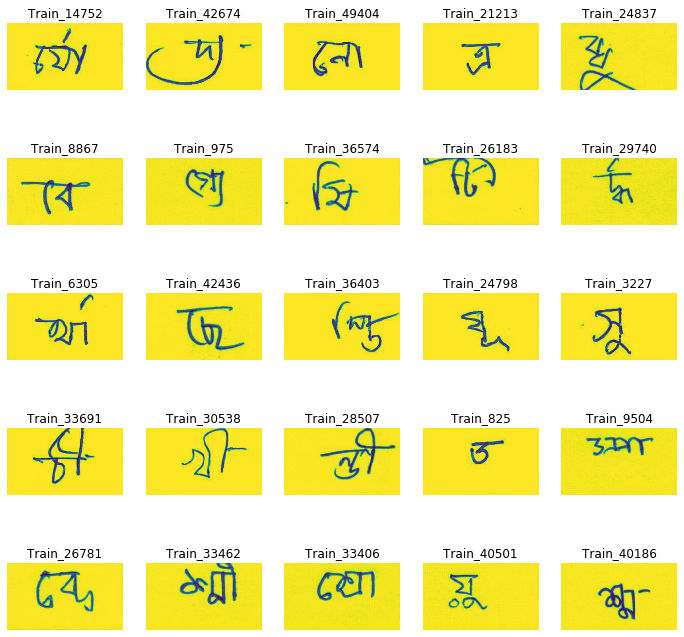

In [45]:
def display_image_from_pixels(data, subplots_size=5):
    plt.figure()
    fig, ax = plt.subplots(subplots_size, subplots_size, figsize=(12,12))
    
    for i, index in enumerate(data.index):
        image_id = data.iloc[i]['image_id']
        flattened_image = data.iloc[i].drop('image_id').values.astype(np.uint8)
        unpacked_image = PIL.Image.fromarray(flattened_image.reshape(137, 236))

        ax[i//subplots_size, i%subplots_size].imshow(unpacked_image)
        ax[i//subplots_size, i%subplots_size].set_title(image_id)
        ax[i//subplots_size, i%subplots_size].axis('off')

display_image_from_pixels(train_0.sample(25))

# 2. Exploratory Data Analysis (EDA)

In [80]:
def show_class_maps():
    print('-----------------')
    print('grapheme_root')
    print(class_map.loc[class_map['component_type'] == 'grapheme_root']['component'].values)
    print('-----------------')
    print('map_vowel')
    print(class_map.loc[class_map['component_type'] == 'vowel_diacritic']['component'].values)
    print('-----------------')
    print('map_diacritic')
    print(class_map.loc[class_map['component_type'] == 'consonant_diacritic']['component'].values)
    
show_class_maps()

-----------------
grapheme_root
['ং' 'ঃ' 'অ' 'আ' 'ই' 'ঈ' 'উ' 'ঊ' 'ঋ' 'এ' 'ঐ' 'ও' 'ঔ' 'ক' 'ক্ক' 'ক্ট' 'ক্ত'
 'ক্ল' 'ক্ষ' 'ক্ষ্ণ' 'ক্ষ্ম' 'ক্স' 'খ' 'গ' 'গ্ধ' 'গ্ন' 'গ্ব' 'গ্ম' 'গ্ল'
 'ঘ' 'ঘ্ন' 'ঙ' 'ঙ্ক' 'ঙ্ক্ত' 'ঙ্ক্ষ' 'ঙ্খ' 'ঙ্গ' 'ঙ্ঘ' 'চ' 'চ্চ' 'চ্ছ'
 'চ্ছ্ব' 'ছ' 'জ' 'জ্জ' 'জ্জ্ব' 'জ্ঞ' 'জ্ব' 'ঝ' 'ঞ' 'ঞ্চ' 'ঞ্ছ' 'ঞ্জ' 'ট'
 'ট্ট' 'ঠ' 'ড' 'ড্ড' 'ঢ' 'ণ' 'ণ্ট' 'ণ্ঠ' 'ণ্ড' 'ণ্ণ' 'ত' 'ত্ত' 'ত্ত্ব'
 'ত্থ' 'ত্ন' 'ত্ব' 'ত্ম' 'থ' 'দ' 'দ্ঘ' 'দ্দ' 'দ্ধ' 'দ্ব' 'দ্ভ' 'দ্ম' 'ধ'
 'ধ্ব' 'ন' 'ন্জ' 'ন্ট' 'ন্ঠ' 'ন্ড' 'ন্ত' 'ন্ত্ব' 'ন্থ' 'ন্দ' 'ন্দ্ব' 'ন্ধ'
 'ন্ন' 'ন্ব' 'ন্ম' 'ন্স' 'প' 'প্ট' 'প্ত' 'প্ন' 'প্প' 'প্ল' 'প্স' 'ফ' 'ফ্ট'
 'ফ্ফ' 'ফ্ল' 'ব' 'ব্জ' 'ব্দ' 'ব্ধ' 'ব্ব' 'ব্ল' 'ভ' 'ভ্ল' 'ম' 'ম্ন' 'ম্প'
 'ম্ব' 'ম্ভ' 'ম্ম' 'ম্ল' 'য' 'র' 'ল' 'ল্ক' 'ল্গ' 'ল্ট' 'ল্ড' 'ল্প' 'ল্ব'
 'ল্ম' 'ল্ল' 'শ' 'শ্চ' 'শ্ন' 'শ্ব' 'শ্ম' 'শ্ল' 'ষ' 'ষ্ক' 'ষ্ট' 'ষ্ঠ' 'ষ্ণ'
 'ষ্প' 'ষ্ফ' 'ষ্ম' 'স' 'স্ক' 'স্ট' 'স্ত' 'স্থ' 'স্ন' 'স্প' 'স্ফ' 'স্ব'
 'স্ম' 'স্ল' 'স্স' 'হ' 'হ্ন' 'হ্ব' 'হ্ম' 'হ্ল' 'ৎ' 'ড়' 'ঢ়' 'য়']
-----------------
map_vowe

In [81]:
# most frequent graphemes train to train_all

In [82]:
# most frequuent class_maps histplot according to train and test

In [83]:
# things existed in train but not in test and vice versa

In [ ]:
# heatmap

# 3. Feature Engineering (FE)

In [1]:
# AugMix
# Centering
# crop
# resize

# 4. Modeling

# 5. Evaluation

# 6. Deployment

# 7. Submission